## Parameters

In [15]:
data_loc = "saved/basic_mnist" # location of input data
save_loc = "saved/basic_mnist" # location to save to (can be the same as above)

reps = 1 #5
epochs = 20 #200 
early_stop = 4 # stop if no improvement in this many epochs
save_all_models = False
latent_dim_options = [6, 8, 12]

## Imports

In [2]:
import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import math

import tensorflow as tf
from my_lib.save_load import load_datasets, save_models
from my_lib.models.common_functions import sampling

In [3]:


all_data = load_datasets(data_loc)

for name, model in all_data.items():
    name = name.split(".")[0]
    exec("{} = model".format(name))
    print("initialized variable,", name)

initialized variable, thicks_d_test
initialized variable, raw_thick_scores
initialized variable, thicks_q_test
initialized variable, y_train
initialized variable, raw_thick_scores_test
initialized variable, y_test
initialized variable, x_test
initialized variable, x_train
initialized variable, thicks_q
initialized variable, thicks_d


In [4]:
# ensure data is normalized
if np.max(x_train) > 200.:
    x_train = x_train/255.
    x_test = x_test/255.

In [5]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
input_shape = (original_dim, )

# Vae

In [6]:

def make_cvae(latent_dim = 8):
    """
    Creates a convolutional variational autoencoder
    
    :param latent_dim: int: size of latent dimension
    
    """
    
    in_enc = Input(shape=(28, 28, 1), name="encoder_inputs")

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides=2, activation='relu')(in_enc)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(2, 2), strides=2, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024,  activation='relu')(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(in_enc, [z_mean, z_log_var, z], name='encoder')


    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

    x = tf.keras.layers.Dense(units=1024, activation="relu")(latent_inputs)
    base= 7
    x = tf.keras.layers.Dense(units=base*base*128, activation="relu")(x)
    x = tf.keras.layers.Reshape(target_shape=(base, base, 128))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=2, padding='same', activation='relu')(x)
    output = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=1, padding='same', activation='sigmoid')(x)
    # outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, output, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(in_enc)[2])
    vae = Model(in_enc, outputs, name='vae_mlp')
    
    reconstruction_loss = mse(in_enc, outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    vae_loss = tf.reduce_mean(reconstruction_loss) + tf.reduce_mean(kl_loss)
    
    vae.add_metric(kl_loss, name="kl_loss", aggregation="mean")
    
    vae.add_metric(reconstruction_loss, name="reconstruction_loss", aggregation="mean")
    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    return vae, encoder, decoder

In [7]:
vae, encoder, decoder = make_cvae()

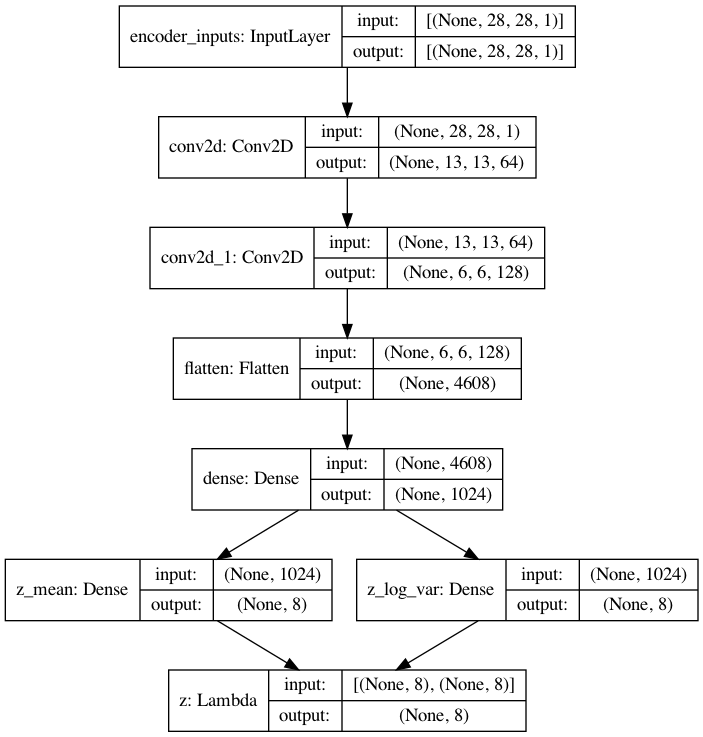

In [8]:
plot_model(encoder, to_file='models/encoder.png', show_shapes=True)

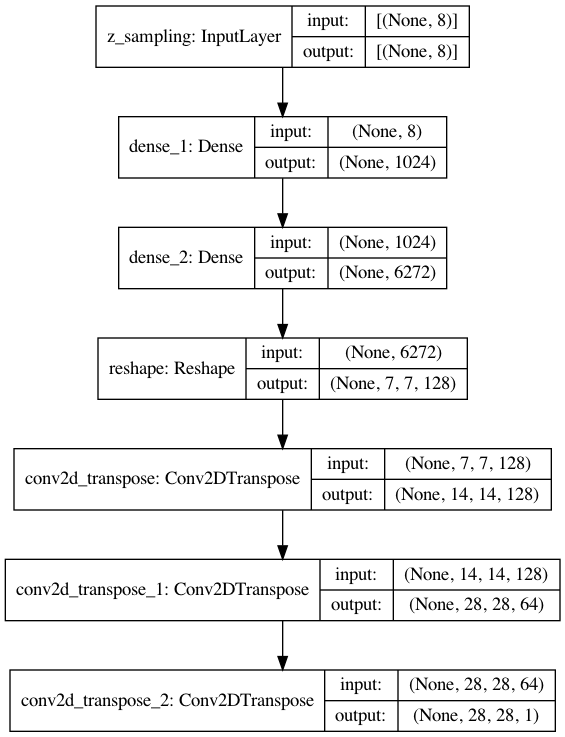

In [9]:
plot_model(decoder, to_file='models/decoder.png', show_shapes=True)

### Run multiple times to determine best latent dimesion (ld)

In [10]:
trained = []

In [11]:


for rep in range(reps):
    for ld in latent_dim_options:
        
        cb = tf.keras.callbacks.EarlyStopping(
            monitor='val_reconstruction_loss', patience=early_stop, restore_best_weights=True
        )

        
        vae, encoder, decoder = make_cvae(ld)
        
        id_str = "{}_{}".format(ld, rep)
        print("\n\n", id_str)
        trained.append((id_str, vae, encoder, decoder))

        vae.fit(x_train,
                epochs=epochs,
                batch_size=32,
                callbacks=[cb],
                validation_data=(x_test, None))


        
        if save_all_models:
            save_to = "{}/all_models/digits_{}d_{}_thick".format(save_loc , ld, rep)
            models = (vae, encoder, decoder)
            save_models(save_to, models)
            print("Saved model to", save_to)
        
        



 6_0
Epoch 1/20
1875/1875 [==============================] - 238s 127ms/step - loss: 45.0913 - kl_loss: 6.8752 - reconstruction_loss: 30.3161 - val_loss: 31.7628 - val_kl_loss: 8.4006 - val_reconstruction_loss: 23.3627
Epoch 2/20
1875/1875 [==============================] - 242s 129ms/step - loss: 31.5332 - kl_loss: 8.9806 - reconstruction_loss: 22.1978 - val_loss: 30.6357 - val_kl_loss: 9.1235 - val_reconstruction_loss: 21.5158
Epoch 3/20
1875/1875 [==============================] - 244s 130ms/step - loss: 30.3760 - kl_loss: 9.2996 - reconstruction_loss: 20.8941 - val_loss: 29.7695 - val_kl_loss: 9.5030 - val_reconstruction_loss: 20.2683
Epoch 4/20
1875/1875 [==============================] - 235s 125ms/step - loss: 29.6935 - kl_loss: 9.4643 - reconstruction_loss: 20.1508 - val_loss: 29.5205 - val_kl_loss: 9.1326 - val_reconstruction_loss: 20.3867
Epoch 5/20
1875/1875 [==============================] - 226s 121ms/step - loss: 29.2436 - kl_loss: 9.5657 - reconstruction_loss: 19.6726 

KeyboardInterrupt: 

### View Results

In [ ]:
from tensorflow.keras.losses import MSE
def check_recons(vae, test_samples):
    
    digit_size = 28
    figure = np.zeros((digit_size * 2, digit_size * len(test_samples), 1))
    
    recons = vae(test_samples)

    
    for r, (img1, img2) in enumerate(zip(test_samples, recons)):
        for c, img in enumerate([img1, img2]):
            
            if len(img.shape) < 3:
                img = np.expand_dims(img, -1) #tf.expand_dims(img, 1)

            figure[c * digit_size: (c + 1) * digit_size,
                   r * digit_size: (r + 1) * digit_size] = img
    
    plt.figure(figsize=(20,20))
    plt.imshow(np.squeeze(figure), cmap="Greys_r")
    plt.axis('off')
    plt.show()
    
    mses = []
    for i in range(len(test_samples)):
        x = tf.reduce_mean(MSE(test_samples[i], recons[i])).numpy()
        x = "{:.3f}".format(x)
        mses.append(x)

    s = " "*10
    print(" ", s.join(mses))
    
    
    return recons


n = 10
test_inds = np.random.choice(np.arange(len(x_test)),size=n, replace=False)
test_samples = x_test[test_inds]
check_recons(vae, test_samples);

In [ ]:
vae.history.history.keys()

In [ ]:
show = 4
key = "val_loss"

def model_sort_key(x):
    try:
        id_str, model = x
        return min(model.track[key])
    except:
        return 1e10

    
    
for i, (id_str, vae, encoder, decoder) in enumerate(sorted(trained, key=model_sort_key)):
    print("Model id:", id_str)

    plt.plot(vae.history.history[key])
    print("Best", key, "=", min(vae.history.history[key]))
    plt.title(key)
    check_recons(vae, test_samples)
        
    plt.show()
        

## Save models

6_0
27.771926879882812


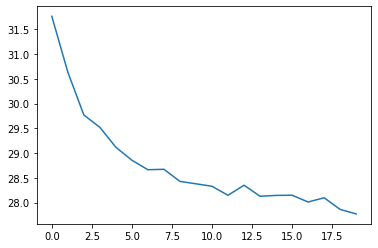

found


In [12]:
find = "6_0"


for id_str, vae, encoder, decoder in trained:

    if id_str == find:
        print(id_str)
        print(min(vae.history.history["val_loss"]))
        plt.plot(vae.history.history["val_loss"])
        plt.show()
        
        print("found")
        break
    

In [16]:

models = (vae, encoder, decoder)
save_models(save_loc, models)

INFO:tensorflow:Assets written to: saved/basic_mnist/models/vae_mlp/assets
INFO:tensorflow:Assets written to: saved/basic_mnist/models/encoder/assets
INFO:tensorflow:Assets written to: saved/basic_mnist/models/decoder/assets


In [14]:
save_loc

'digits_6d_0_thick'